# Aplicações com PaliGemma




## Instalando bibliotecas

Se você estiver rodando no colab, não é necessário executar esse passo.

In [ ]:
!pip install transformers torch Pillow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 28.1 MB/s eta 0:00:00


## Importando bibliotecas

In [ ]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import requests
import torch

## Inicializando o PaliGemma

Aqui, como queremos já sair usando, iremos escolher o modelo mix, pois o mesmo foi já foi treinado em diversas tarefas.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16).eval()
model = model.to(device)
processor = AutoProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

## Testando diferentes aplicações

Estilo de prompt que usaremos:

* cap {lang}\n: very raw short caption (from WebLI-alt).

* caption {lang}\n: nice, coco-like short captions.

* describe {lang}\n: somewhat longer more descriptive captions.

* ocr\n: optical character recognition.

* answer en {question}\n: question answering about the image contents.

* question {lang} {answer}\n: question generation for a given answer.

* detect {thing}\n: count objects in a scene.

In [ ]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
car_image = Image.open(requests.get(url, stream=True).raw)

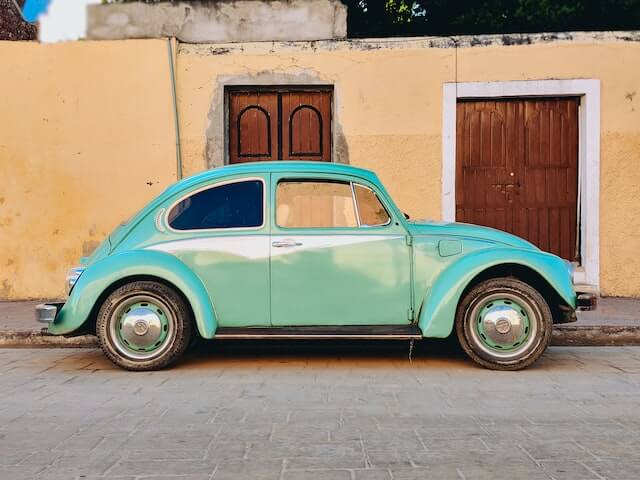

In [ ]:
car_image

In [ ]:
def predict(prompt, image):
  model_inputs = processor(text=prompt, images=image, return_tensors="pt")
  model_inputs = model_inputs.to(device=device, dtype=model.dtype)
  input_len = model_inputs["input_ids"].shape[-1]

  with torch.inference_mode():
      generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
      generation = generation[0][input_len:]
      decoded = processor.decode(generation, skip_special_tokens=True)
  return decoded

### Gerar legendas

In [ ]:
prompt = "cap ptbr"
predict(prompt, car_image)

'Um carro azul estacionado na beira de uma rua.'

### Responder perguntas

In [ ]:
prompt = "answer ptbr quantas pneus aparecem na imagem?"
predict(prompt, car_image)

'2'

### OCR

In [ ]:
from google.colab import files
from io import BytesIO

uploaded = files.upload()
im = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]])).convert("RGB")

Saving Screenshot 2024-07-05 at 02.13.21.png to Screenshot 2024-07-05 at 02.13.21.png


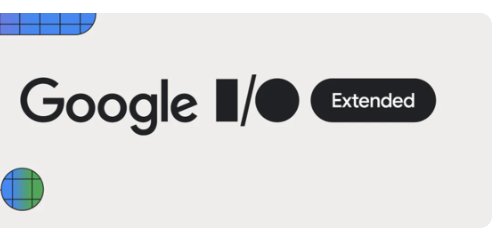

In [ ]:
im

In [ ]:
prompt = "ocr"
predict(prompt, im)

'Google I/O\nExtended'

### Detectar objetos

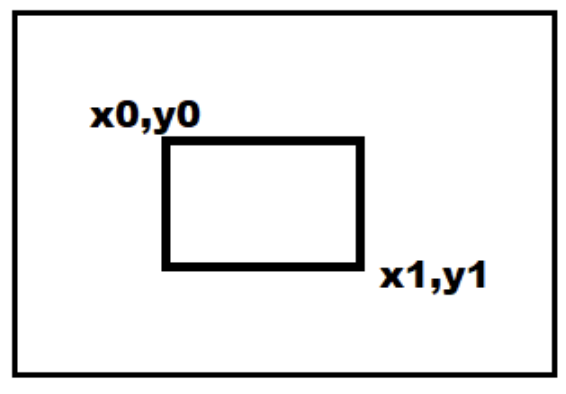

In [ ]:
subject = "wheel"
prompt = f"detect {subject}"
decoded = predict(prompt, car_image)
decoded

'<loc0591><loc0150><loc0790><loc0267> wheel ; <loc0591><loc0724><loc0788><loc0880> wheel'

In [ ]:
def parse_detection(text, subject):
  objects = text.split(";")
  positions = []
  for obj in objects:
    obj_positons = []
    for raw_pos in obj.strip().split("><"):
      position = raw_pos.replace(">", "").replace("<", "").replace("loc", "").replace(subject, "").strip()
      position = int(224 * int(position) / 1024)
      obj_positons.append(position)
    positions.append(((obj_positons[1], obj_positons[0]), (obj_positons[3], obj_positons[2])))
  return positions

In [ ]:
parse_detection(decoded, subject)

[((32, 129), (58, 172)), ((158, 129), (192, 172))]

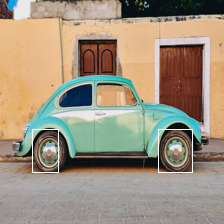

In [ ]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

source_img = car_image.resize((224,224))
draw = ImageDraw.Draw(source_img)

for position in parse_detection(decoded, subject):
  draw.rectangle(position)

source_img